In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [2]:
%pwd
%cd ir_data/GL-05-52

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-05-52


### Load Raw Data

In [3]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
#Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [4]:
# Instantiate class - doesn't work as Peaks(ir_data), I have to use Peaks = Peaks(ir_data), why?
Peaks = Peaks(ir_data)

In [5]:
# Determine the peak prominences of every wavelength
#processed_ir_data = Peaks.prominence_all(0.032)

# Determine the peak prominences of a single wavelength
processed_ir_data = Peaks.prominence(0.032,'Peak at 1704 cm-1')

# Determine the peak heights of a single wavelength
#processed_ir_data = Peaks.height(0.0505,'Peak at 1704 cm-1')

# Determine the experimental areas of a single wavelength
#processed_ir_data = Peaks.exp_area(0.032, 4, 'Peak at 1704 cm-1', 1.1, -0.4)

# Determine the fitted areas of a single wavelength
#processed_ir_data = Peaks.fitted_area(0.032, 4, 'Peak at 1704 cm-1', 1.1, -0.4)

# Fit a gaussian to a single peak and determine it's area
#processed_ir_data= Peaks.fitted_area_sp(0.05, 4, 'Peak at 1704 cm-1', 1.1, -0.4, 8)

# Compare prominence, height, experimental area, and fitted area
#r2, compare = Peaks.compare(0.0505, 0.032, 4,'Peak at 1704 cm-1', 4, 10, 1.1, -0.4)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

# Visualise which peaks have been picked - single peak
#Peaks.plot(processed_ir_data, 'Peak at 1704 cm-1')

#processed_ir_data
#r2

### Read experimental conditions and add to dataframe

In [6]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  40 , Number of conditions =  40


### Create the SPKA profiles

In [7]:
SPKA2 = SPKA(experimental_data)

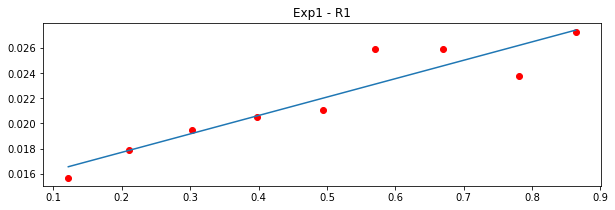

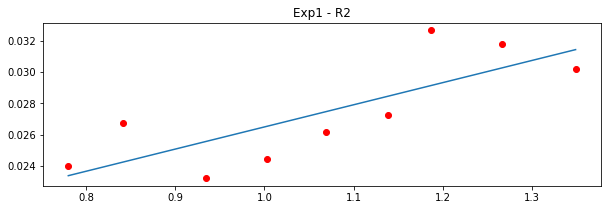

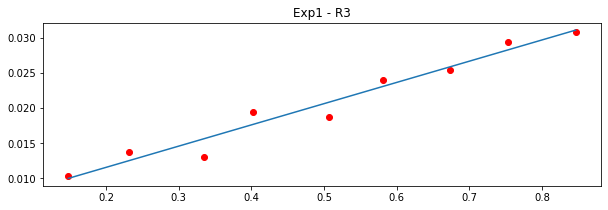

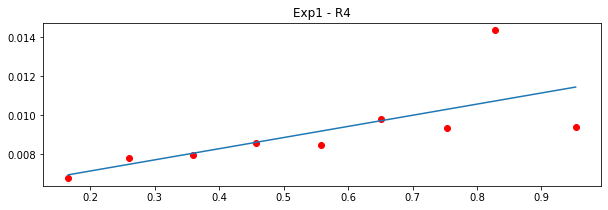

In [8]:
spka_data = SPKA2.spka('[A]0')
spka_data
SPKA2.plot(spka_data)
#r2 = SPKA2.compare('[A]0')
#r2

### Perform RPKA

In [9]:
RPKA = RPKA(spka_data)

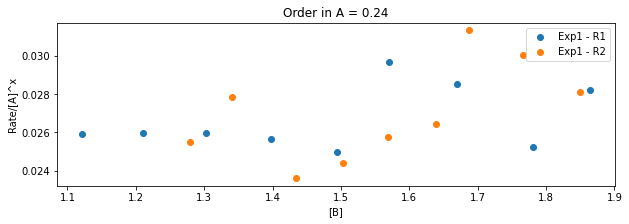

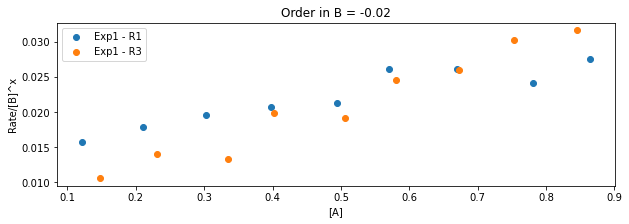

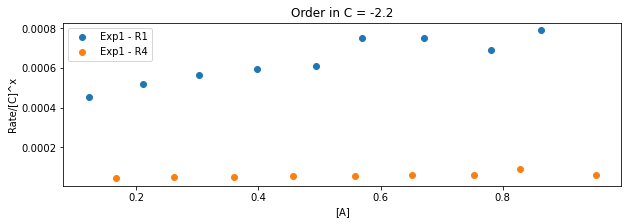

In [10]:
rpka_data = RPKA.diff_excess()
#rpka_data

In [11]:
# Some definitions

# For RPKA - first experiment
def func_exp1(x):
    return rate_exp_a/(yconc_exp_a**x) - x_exp_a

# For RPKA - second experiment
def func_exp4(x):
    return rate_exp_b/(yconc_exp_b**x) - x_exp_b

# Residuals for RPKA
def residuals(x):
    return (rate_exp_a/(yconc_exp_a**x) - rate_exp_b/(yconc_exp_b**x))

def sum_residuals(x):
    return sum(residuals(x)**2)

In [12]:
rpka_data = spka_data.drop(columns=['Interval Size',
                                   'tR (min)',
                                   'SPKA',
                                   'Relative Time',
                                   'Peak Property',
                                   'Method',
                                   'SPKA Conversion',
                                   'SPKA Ideal t0 Concentration',
                                   'Normalised IR Concentration'])

In [13]:
reaction_list = rpka_data['Experiment'].unique()

# Calculate Excess
rpka_data['[Excess]'] = rpka_data['[B]0'] - rpka_data['[A]0']
rpka_data['[B]'] = rpka_data['[A]'] + rpka_data['[Excess]']
rpka_data['[C]'] = rpka_data['[C]0']

# Determine which experiments look at which reagent
rpka_experiments = {}

for var in range(1, len(reaction_list)):
    
    # Select the first experiment and the nth experiment
    tmp = rpka_data.loc[rpka_data['Experiment'].isin([reaction_list[0],reaction_list[var]])]

    # Drop all columns which have only a single unique value, the second column is now the reagent we want - THIS MIGHT CAUSE PROBLEMS
    nunique = tmp.nunique()
    cols_to_drop = nunique[nunique == 1].index
    tmp = tmp.drop(cols_to_drop, axis=1)
    
    # The second columnd will contain the compound which is changing
    rpka_reagent = tmp.columns[1]
    rpka_reagent = rpka_reagent[rpka_reagent.find("[")+1:rpka_reagent.find("]")]
    
    rpka_experiments[reaction_list[var]] = rpka_reagent

rpka_experiments

{'Exp1 - R2': 'A', 'Exp1 - R3': 'B', 'Exp1 - R4': 'C'}

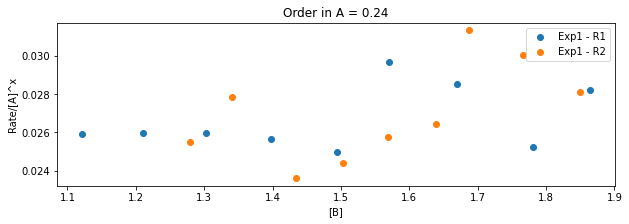

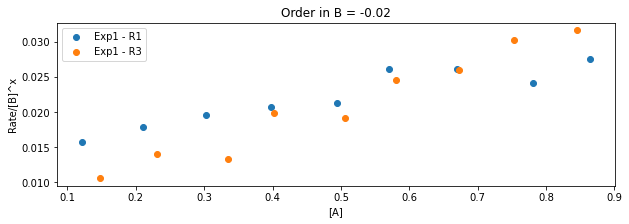

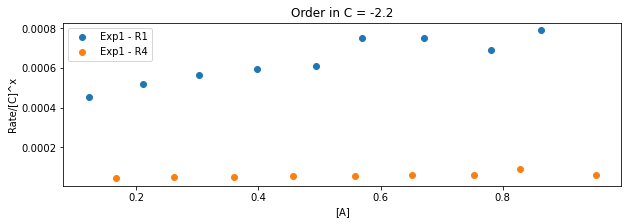

In [14]:
# RPKA loop

for var in range(1, len(reaction_list)):
    
    # exp_a will always be R1
    exp_a = reaction_list[0]
    exp_b = reaction_list[var]
    
    # Define substrate to process
    rpka_reagent = rpka_experiments[reaction_list[var]]
    
    # Check whether the reagent is the limiting reagnet (should be A, the first entry) or not as axes will be different
    if rpka_reagent == rpka_experiments[reaction_list[1]]:

        reagent_on_y_axis = '[' + rpka_experiments[reaction_list[1]] + ']'
        reagent_on_x_axis = '[' + rpka_experiments[reaction_list[var+1]] + ']'

    else:

        reagent_on_y_axis = '[' + rpka_experiments[reaction_list[var]] + ']'
        reagent_on_x_axis = '[' + rpka_experiments[reaction_list[1]]  + ']'   

    # Define exp_a
    x_exp_a = rpka_data[reagent_on_x_axis].loc[rpka_data['Experiment'] == exp_a].to_numpy()
    rate_exp_a = rpka_data['Rate'].loc[rpka_data['Experiment'] == exp_a].to_numpy()
    yconc_exp_a = rpka_data[reagent_on_y_axis].loc[rpka_data['Experiment'] == exp_a].to_numpy()

    # Define exp_b
    x_exp_b = rpka_data[reagent_on_x_axis].loc[rpka_data['Experiment'] == exp_b].to_numpy()
    rate_exp_b = rpka_data['Rate'].loc[rpka_data['Experiment'] == exp_b].to_numpy()
    yconc_exp_b = rpka_data[reagent_on_y_axis].loc[rpka_data['Experiment'] == exp_b].to_numpy()

    # Calculate order
    reagent_order = np.round(minimize(sum_residuals, 1).x,2)
    rpka_data['Order in ' + rpka_reagent] = pd.Series(reagent_order)
    
    # Plot
    fig = plt.figure(figsize=(10,3))
    plt.title('Order in ' + rpka_reagent + ' = ' + rpka_data['Order in ' + rpka_reagent].iloc[0].astype(str))
    plt.xlabel(reagent_on_x_axis)
    plt.ylabel('Rate/' + reagent_on_y_axis + '^x')
    plt.scatter(x_exp_a, rate_exp_a/yconc_exp_a**rpka_data['Order in ' + rpka_reagent].iloc[0], label = exp_a)
    plt.scatter(x_exp_b, rate_exp_b/yconc_exp_b**rpka_data['Order in ' + rpka_reagent].iloc[0], label = exp_b)   
    plt.legend()
    
#rpka_data.fillna(method="ffill")

In [15]:
exp_a

'Exp1 - R1'

In [16]:
exp_b

'Exp1 - R4'

In [17]:
reagent_on_y_axis

'[C]'

In [18]:
reagent_on_x_axis

'[A]'

In [19]:
reaction_list

array(['Exp1 - R1', 'Exp1 - R2', 'Exp1 - R3', 'Exp1 - R4'], dtype=object)

In [20]:
rpka_experiments

{'Exp1 - R2': 'A', 'Exp1 - R3': 'B', 'Exp1 - R4': 'C'}

In [22]:
rpka_experiments[reaction_list[3]]

'C'

In [23]:
rpka_data

,Experiment,A,B,C,[A]0,[B]0,[C]0,Rate,[A],[Excess],[B],[C],Order in A,Order in B,Order in C
0,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0272668,0.863666,1.0,1.86367,0.2,0.24,-0.02,-2.2
1,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0237977,0.781012,1.0,1.78101,0.2,NaN,NaN,NaN
2,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0259037,0.670482,1.0,1.67048,0.2,NaN,NaN,NaN
3,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0259209,0.570396,1.0,1.5704,0.2,NaN,NaN,NaN
4,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0210901,0.49455,1.0,1.49455,0.2,NaN,NaN,NaN
5,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.020547,0.397265,1.0,1.39726,0.2,NaN,NaN,NaN
6,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0194916,0.302542,1.0,1.30254,0.2,NaN,NaN,NaN
7,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0178815,0.210593,1.0,1.21059,0.2,NaN,NaN,NaN
8,Exp1 - R1,A1,B1,C1,1.0,2.0,0.2,0.0156452,0.121774,1.0,1.12177,0.2,NaN,NaN,NaN
9,Exp1 - R2,A1,B1,C1,1.5,2.0,0.2,0.0301806,1.3491,0.5,1.8491,0.2,NaN,NaN,NaN


## Go through manually for C

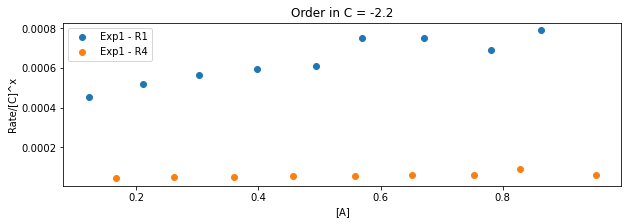

In [24]:
var = 3
    
# exp_a will always be R1
exp_a = 'Exp1 - R1'
exp_b = 'Exp1 - R4'

# Define substrate to process
rpka_reagent = 'C'

reagent_on_y_axis = '[C]'
reagent_on_x_axis = '[A]'

# Define exp_a
x_exp_a = rpka_data[reagent_on_x_axis].loc[rpka_data['Experiment'] == exp_a].to_numpy()
rate_exp_a = rpka_data['Rate'].loc[rpka_data['Experiment'] == exp_a].to_numpy()
yconc_exp_a = rpka_data[reagent_on_y_axis].loc[rpka_data['Experiment'] == exp_a].to_numpy()

# Define exp_b
x_exp_b = rpka_data[reagent_on_x_axis].loc[rpka_data['Experiment'] == exp_b].to_numpy()
rate_exp_b = rpka_data['Rate'].loc[rpka_data['Experiment'] == exp_b].to_numpy()
yconc_exp_b = rpka_data[reagent_on_y_axis].loc[rpka_data['Experiment'] == exp_b].to_numpy()

# Calculate order
reagent_order = np.round(minimize(sum_residuals, 1).x,2)
rpka_data['Order in ' + rpka_reagent] = pd.Series(reagent_order)

# Plot
fig = plt.figure(figsize=(10,3))
plt.title('Order in ' + rpka_reagent + ' = ' + rpka_data['Order in ' + rpka_reagent].iloc[0].astype(str))
plt.xlabel(reagent_on_x_axis)
plt.ylabel('Rate/' + reagent_on_y_axis + '^x')
plt.scatter(x_exp_a, rate_exp_a/yconc_exp_a**rpka_data['Order in ' + rpka_reagent].iloc[0], label = exp_a)
plt.scatter(x_exp_b, rate_exp_b/yconc_exp_b**rpka_data['Order in ' + rpka_reagent].iloc[0], label = exp_b)   
plt.legend()
    

In [ ]:
yconc_exp_b

In [ ]:
minimize(sum_residuals,1)

In [ ]:
sum_residuals(-2.2)

In [ ]:
sum_residuals(1.4)